In [1]:
# RUN THIS FIRST
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# Session 3

The aim of this notebook is to cover one or two more features of Astropy and introduce some packages from outside the standard library that might be useful. If you're comfortable with the material covered in previous sessions, you can explore these packages for yourself. If not, then carry on working through the earlier notebooks and/or applying what you've learned to your own projects.

Please share any other useful knowledge/techniques/packages you might have come across!

## Previous challenges

A solution to the challenge to match lists of integers using `numpy.searchsorted` is in the file `match.py`. In the same file I've included some routines to test the function. The last of these test routines generates huge random unsorted lists of integers to time how long the match takes. That function can be run from the command line (using `if __name__ == '__main__'`) passing the lengths of the two lists to match.

In [ ]:
%run match.py 10000 1000000

Another challenge was to reproduce a fancy 2D histogram of a projected particle distribution with 1D histograms along each axis. The solution to this is in `w2challenge_dotplot.py`. This plots all three possible projections.

In [ ]:
%run w2challenge_dotplot.py

## Installing other packages with `conda` or `pip`

*This is a long section. Bottom line: I recommend using `conda` to install packages if you can.*

To install some of the packages below, you will need to use either `conda` or `pip`. `conda` is a tool for creating self-contained 'environments' in which you can install software separately from anything else on the system. Miniconda and Anaconda are 'distributions' (collections) of python packages that rely on `conda` to install those packages: the distributions provide the packages, and you use the `conda` tool to manage them. `conda` is not specifically linked to Python (more on this below).

`pip` is something much simpler than `conda`. More or less, `pip` is a tool to install *only* Python packages. `pip` knows about  one big official archive of Python packages on the web (rather than 'distributions' like Anaconda). Unlike `conda`, `pip` will try to to install packages in a default system location, which usually needs the root password to write to. If you are working on someone else's machine or want to keep packages out of the system python directory, you can ask `pip` to install to a specific directory under your control, or to a default location in your `/home` director (examples follow below).

In the past almost everyone used `pip`. Now more people are using `conda`: one problem with `conda` is that the learning curve is slightly steeper than `pip`, because of the idea of 'environments' in `conda`. The advantage is that `conda` can install a wider range of software, and can isolate everything very cleanly from the version of Python used by the operating system. The advantage of `pip` is that it is less hassle and is more-or-less built in to Python (`conda` has to be installed separately, almost always this is done by installing Miniconda or another distribution that relies on `conda`.

*** To install packages with `conda`: ***

`conda install [name of package]`

To make a `conda` environment with `numpy`, `matplotlib` and `astropy` in it you can do:

`conda create myenvironment numpy matplotlib astropy`

Then you need to activate that environment when you work: `source activate myenvironment`. The shell prompt will change to show you're working in that environment. To list the packages available in the environment, you can do `conda list`. If you install new packages inside an environment, they will only be available inside that environment. You can have separate environments for Python 2, Python 3 and any other particular version of Python you want. You can use `pip` inside a `conda` environment too, and the effect will be to install the package in that environment, not system-wide.

When you're done with the environment, `source deactivate`.

This seems like a lot of hassle at first, but it does make things easier in the long run.

*** To install packages with `pip`: ***

`pip install [name of package]`

Add the `--user` option if you don't have/want to use root access to install to the system python directory.

You can also use the option `--prefix=/some/path/on/your/disk` to install a package to a specific location. Remember that this location will have to be added to your PYTHONPATH (or otherwise added into the list `sys.path` at runtime) before you can `import` the package.

** Non-python dependencies **

Some python packages might depend on non-python code. For example, the packages that work with the HDF5 format will require your system to have the HDF5 libraries installed, and the `healpy` package requires the `HEALPIX` libraries. Conda is particularly useful because it can also install any non-python libraries and software that a given python package depends on. `pip` only does this 'sometimes' for the bigger, better-supported packages (for example, installing `numpy` involves compiling some well-tested, high-performance numerical libraries written in C and Fortran, but this is handled by `pip`).

If you don't use `conda` but you have linux, then these external dependencies can usually be installed with your package manager. For macs there are third-party package managers like [Homebrew](http://brew.sh/). 

Conda will nearly always install these third-party librarys for you automatically -- my suggestion is to use `conda` for an easy life.

## Astropy continued

Last week we covered:
- coordinate conversions using `astropy.coordinates.SkyCoord`
- using the `astropy.table.Table` class to read FITS tables

This week we'll look at:
- using the `astroquery` add-on package to `astropy` to get data from SDSS (and other databases)
- finding neighbours of points on the sky
- a quick note on the cosmology tools in `astropy`

### Astroquery

Astroquery is a package that can communicate over the internet with various astronomy databases, including the `simbad` tool to turn names of astronomical objects into (RA,DEC) coordinates, and the Sloan Digital Sky Survey.

This is an 'affiliated package' of `astropy`. According to the webpage, it can be installed as follows with `conda`: `conda install -c astropy astroquery`. The `-c astropy` option tells `conda` to use the `astropy` channel to install the `astroquery` package. Channels are online repositories of packages: Anaconda is one such repository, but there are others, including astropy. Different repositories provide different collections of packages.

Once `astroquery` is installed:

In [ ]:
import astroquery # When you first do this, you might get a harmless warning about the configuration

We also need the `astropy` coordinates and units modules"

In [ ]:
import astropy.coordinates as c
import astropy.units as u

NGC 2419 is an unusual Milky Way globular cluster. This example shows how to use `astroquery` to find where the cluster is and download nearby sources in SDSS. 

First, use a [Simbad](http://simbad.u-strasbg.fr/simbad/) query to find the coordinates of the cluster.

In [ ]:
simbad  = astroquery.simbad.Simbad()
ngc2419 = simbad.query_object('NGC 2419')

Convert this to an `astropy` coordinate object:

In [ ]:
ngc2419_pos = c.SkyCoord(ngc2419['RA'],ngc2419['DEC'],unit=(u.hourangle,u.degree))
print(ngc2419_pos)

Now use this position for another query, this time to SDSS. We'll download all the entries in the photometric detection table (`photoobj`) within 10 arcminutes of the position of the cluster. We'll ask for position (ra and dec), the 'g' and 'r' band PSF magnitudes (the appropriate magnitudes to use for for stars), the SDSS source class (`type`) and the standard set of SDSS identifiers (objid, run, rerun, camcol and field) which are not used in this example, but which would be useful if we wanted to carry out further queries, e.g. for spectra or additional properties). 

In [ ]:
sdss = astroquery.sdss.SDSS()
res = sdss.query_region(ngc2419_pos,radius=10*u.arcmin,
                       photoobj_fields=['ra','dec','objid','run','rerun','camcol','field',
                                        'psfMag_g', 'psfMag_r','type'])

Make a quick plot of the sources to check we have something reasonable:

In [ ]:
pl.figure(figsize=(4,4))
pl.scatter(res['ra'],res['dec'],s=1,edgecolor='None');

Note that there is an 'empty' ring around the cluster position with no points in it -- this is because the SDSS photometry pipeline fails in very crowded fields. The second empty region to the 'left' (in this case, west) of the cluster is because there's a bright star there, which also confuses SDSS.

We can also get an image of the cluster. In this example we'll use the SDSS g band. For this we use a SkyView query: we could have used SDSS.get_images, but SkyView can join together multiple SDSS fields into a single image -- this would be much harder to do if we got the individual images from SDSS ourselves.

In [ ]:
skyview = astroquery.skyview.SkyView()

# skyview.list_surveys() shows the various image sources.
# This takes a while
im = skyview.get_images(ngc2419_pos,survey=['SDSSg'],radius=20.0*u.arcmin)
pl.imshow(im[0][0].data,cmap='viridis',origin='lower',vmax=0.5);

We want degrees rather than pixels on the axes. We also want to make sure the sky projection is correct (after all, these pixels we're looking at are projections onto a spherical surface). The seriously difficult business of projecting stuff onto the sphere of the sky in various ways is dealt with by a convention called WCS. WCS stands for World Coordinate System. Ask your supervisor to explain what WCS is and why it's important (if they are a theorist, you may get a blank look). The basic idea is that most astronomical images (those that come from professional telescopes) carry around information about how to project their pixels. 

Fortunately, we can get a WCS definition from the header of the image we got in the previous cell. (If you've never seen a FITS header before you can execute the following cell).

In [ ]:
im[0][0].header # Just to show you what a FITS header (with WCS keywords) looks like.

In [ ]:
pl.figure(figsize=(5,5))

h   = im[0][0]
wcs = astropy.wcs.WCS(h.header)

pl.subplot(111,projection=wcs)

# Plot the image
pl.imshow(im[0][0].data,cmap='viridis',origin='lower',vmax=0.5,alpha=0.5)

# Use the WCS to convert the coordinates of the points to the pixel
# coordinates of the image.
rapix, decpix = wcs.all_world2pix(c.Angle(res['ra'],u.degree),c.Angle(res['dec'],u.degree),1)

# Plot the points
pl.scatter(rapix,decpix,s=1,c='k',edgecolor='None');
pl.grid(True,color='k')

# Mark the cluster with a dot.
# This is another way to convert to WCS
x,y = ngc2419_pos.to_pixel(wcs)
pl.scatter(x,y,c='r',s=25)

# Draw a label for this point using annotate, a slightly complicated
# function from matplotlib.
pl.annotate('NGC 2419',(x,y),(x+100,y-100),color='k',fontsize=10,
            arrowprops=dict(arrowstyle="-", connectionstyle='arc'),
            bbox=dict(facecolor='white', edgecolor='k',boxstyle='round'));

# Store the axes object, we'll need it in a moment
ax = pl.gca()

# Plot a circle of radius 5 arcmin around the cluster. 

# From the astropy documentation on SphericalCircle:
# This class is needed in cases where the user wants to add a circular patch
# to a celestial image, since otherwise the circle will be distorted, because 
# a fixed interval in longitude corresponds to a different angle on the sky 
# depending on the latitude.
from astropy.visualization.wcsaxes import SphericalCircle
my_circle = SphericalCircle((ngc2419_pos.ra,ngc2419_pos.dec),
                      5.0*u.arcmin, edgecolor='k', facecolor='None',
                      transform=ax.get_transform('icrs'))

# Put the circle onto the axes.
ax.add_patch(my_circle)

# Finally format the plot a bit.

# See here for how to format the tick marks
# http://wcsaxes.readthedocs.io/en/latest/ticks_labels_grid.html
    
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.set_ticks(spacing=5.0 * u.arcmin)
lat.set_ticks(spacing=5.0 * u.arcmin)

pl.xlabel(r'$\alpha$ $(\degree)$')
pl.ylabel(r'$\delta$ $(\degree)$');

### Finding points within a spherical angular range

Notwithstanding the missing sources near the cluster, let's make a (rough!) colour magnitude diagram for the cluster. To do that we need to isolate points from the SDSS catalogue that are within some distance (in this case we'll take 5 arcmin) of the centre. Astropy coordinate objects have a `separation` method that takes a list of coordinates and calculates their separation to that point. There are several associated routines to match catalogues (two big arrays of coordinates) by position, but I haven't included examples of those.

In [ ]:
pl.figure(figsize=(4,4))

# First make a colour magnitude diagram of all points
rmag = res['psfMag_r']
gmr  = res['psfMag_g']-res['psfMag_r']
pl.scatter(gmr,rmag,s=1,c='k',edgecolor='None',label='All sources')
pl.xlim(-1,2)
pl.ylim(23,14)
pl.xlabel('$g-r$',fontsize=12)
pl.ylabel('$r$',fontsize=12)

# Overplot objects classified as stars
is_sdss_star = res['type'] == 6
pl.scatter(gmr[is_sdss_star],rmag[is_sdss_star],s=1,c='c',edgecolor='None',label='STAR class');

# 
photo_points  = c.SkyCoord(res['ra'],res['dec'],unit=u.degree)
nearby       = ngc2419_pos.separation(photo_points).arcmin < 4
nearby_points = np.where(nearby & is_sdss_star)[0]
pl.scatter(gmr[nearby_points],rmag[nearby_points],s=5,c='r',edgecolor='None',label='NGC 2419 ($<5$")')
pl.legend(loc='upper left',frameon=True,fontsize=9);


The red points clearly show the line of the globular cluster's giant branch and horizontal branch. The cyan spike to the right of the plot (around g-r = 1.5) is the metal-rich main sequence of disk stars.

### SciServer

If you work a lot with SDSS data, you should get an account on [SciServer](http://www.sciserver.org/) rather than using `astroquery`. SciServer lets you work with SDSS data remotely rather than having to pull it over the web to your machine. The standard way to interact with SciServer is through Jupyter notebooks and ipython sessions, so this tutorial should have been good preparation for that.

### Cosmology

[This](http://www.astropy.org/astropy-tutorials/edshift_plot.html) is a good introduction to the `astropy.cosmology` subpackage, for working with relations between redshift, distance, age, angular diameter, luminosity and so on, for different cosmological parameters.

# AstroML

This is a package that provides a lot of tools for 'data mining', 'Bayesian inference' and 'machine learning' with a strong astronomy focus. These sound like fancy buzzwords, but they are probably some of the most important techniques in astronomy in the next decade, for theorists as well as observers. The authors of AstroML and the accompanying book include two of the most senior astronomers in the Large Synoptic Survey Telescope (LSST) project. 

A list of the topics covered is given in the [user guide](http://www.astroml.org/user_guide/index.html). The code to make the plots from the book is available at the website, but there is no tutorial -- they want you to buy the book. Copies are available in the library.

A closely related (but less astronomy-oriented) package is [`scikit-learn`](http://scikit-learn.org/stable/) (`astroML` itself builds on that package). 

The following example is reproduced (without permission, and with modification!) from the astroML package/website.

This example has an extra level of complexity -- rather than considering the x and y errors as independent, it includes a covariance between them that is different for each data point. It doesn't get much more complicated than this when fitting a straight line. You'll need to read the book for details.

In [2]:
# Author: Jake VanderPlas
# (Modified for the Durham Postgrad Astro course by Andrew Cooper)
#
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np

from scipy              import optimize
from matplotlib         import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model  import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets      import fetch_hogg2010test

#------------------------------------------------------------
# These two functions are just to make the plot at the end, they're
# not related to the fitting.

def get_principal(sigma_x, sigma_y, rho_xy):
    """
    Compute the ellipse pricipal axes and rotation from covariance.
    """
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2, (sigma_x ** 2 - sigma_y ** 2))
    tmp1  = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2  = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha

def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    """
    Plot ellipses (used to represent the data with covariant errors).
    """
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))
    return

Get the data -- this is the same data we saw in session 2 for the straight line fit challenge.

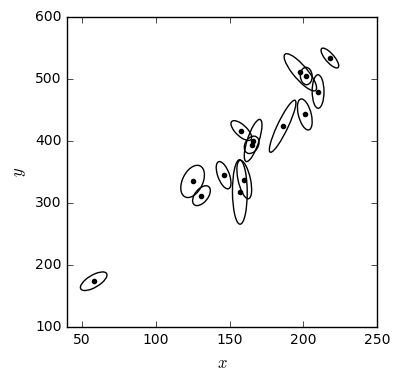

In [3]:
data = fetch_hogg2010test()
data = data[5:]  # no outliers

x       = data['x']
y       = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy  = data['rho_xy']

# Plot the data
fig = plt.figure(figsize=(4,4))
ax  = fig.add_subplot(111)

ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)
ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$',fontsize=12)
ax.set_ylabel('$y$',fontsize=12);

The next cell contains the code to do the maximum likelihood fit. You'll need to look at the book to figure out the maths of what's going on here.

In [6]:
# Find best-fit parameters.
X  = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

# Minimize the log-likelihood
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, x0=[-1, 1])

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


Finally make the plot with the fit, assuming the cells above have been executed.

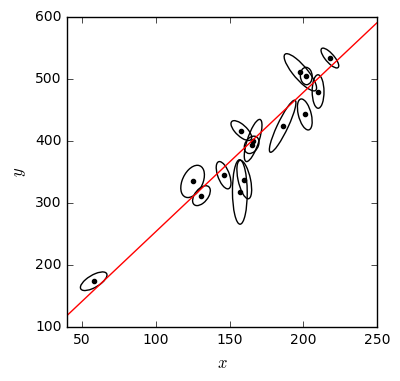

In [7]:
# A convienience function
def get_m_b(beta):
    """
    Translate between typical slope-intercept representation,
    and the normal vector representation.
    """
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


# Plot the data and fits
fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)

ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

# Plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit        = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-r')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$',fontsize=12)
ax.set_ylabel('$y$',fontsize=12);

We can also make a plot of the likelihood contours in the space of the two parameters `m` and `b`.

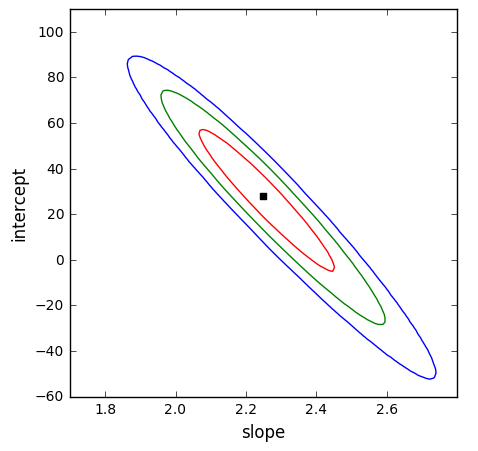

In [8]:
fig = plt.figure(figsize=(5, 5))
ax  = fig.add_subplot(111)

def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])

# Computing the log likelihood for a grid of (m,b):
m    = np.linspace(1.7, 2.8, 100)
b    = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

# Plot the contours
ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors=['r','g','b'])
ax.set_xlabel('slope',fontsize=12)
ax.set_ylabel('intercept',fontsize=12)
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

# Plot the best-fit value
pl.scatter(m_fit,b_fit,c='k',marker='s');

# HDF5 with `pytables` or `h5py`

HDF5 is probably the best format for large binary datasets with complicated structure (better than fits, because FITS gets rather tricky for multidimensional array data, and for data split into many small groups). 

Many simulation codes (especially those favoured at Durham) output their results as HDF5. If you're saving more than `>100 Mb` of data, HDF5 is more practical than `pickle` or `numpy.savez`, and more portable.

HDF5 files are collections of arrays (called 'datasets') arranged out in nested structure a bit like a file system (rather than directories with files in them, there are 'groups' with datasets in them) -- you could also think of them as being similar to Python `dicts`. It's possible to associate 'attributes' ('headers', like comments or units) with individual datasets and to compress them to save disk space.

There are two packages to deal with HDF5 in python: [`h5py`](http://www.h5py.org/) and [`pytables`](http://www.pytables.org/). The style of these packages is slightly different, with `pytables` being slightly closer to the way of working with hdf5 in `C` and focusing on high performance, and `h5py` being more abstract and closer to other python packages like `numpy`, focused on ease of use. The differences are described by the authors of `pytables` [here](http://www.pytables.org/FAQ.html#how-does-pytables-compare-with-the-h5py-project) and by the `h5py` team [here](http://docs.h5py.org/en/latest/faq.html#what-s-the-difference-between-h5py-and-pytables). For general use either is probably fine.

#### Challenge

Install `h5py` and read the [quick start page](http://docs.h5py.org/en/latest/quick.html) and [instructions for readoing and writing datasets](http://docs.h5py.org/en/latest/high/dataset.html) to figure out how to create an HDF5 file and read it back in. This is an example. 

In [9]:
import h5py

# Fake data
mass_dm    = np.random.random(100)
mass_stars = np.random.random(100)
age_stars  = np.random.random(100)

# Write a file
f = h5py.File('mydata.hdf5', mode='w')
try: # (see following notes for an explanation of try..finally..)
    f.create_dataset('/dm/mass',    data=mass_dm)
    f.create_dataset('/stars/mass', data=mass_stars)
    f.create_dataset('/stars/age',  data=age_stars)
finally:
    f.close()

# Read the same file back
g = h5py.File('mydata.hdf5',mode='r')
try:
    y = g['/stars/mass']
    
    # As long as the file is open, the array can be accessed.
    print('type of y: {}'.format(type(y)))
    print('y is {}'.format(y))
    print('First 10 elements of y: {}'.format(y[0:10]))
    
    # If you want to use the data after the file is closed,
    # store its `value`
    z = y.value[0:10]
finally:
    g.close();
print("After we've closed the file...")
print('z is {}'.format(z))
print('y is {}'.format(y))

type of y: <class 'h5py._hl.dataset.Dataset'>
y is <HDF5 dataset "mass": shape (100,), type "<f8">
First 10 elements of y: [ 0.26284014  0.03186374  0.84063572  0.39043774  0.07148305  0.60466286
  0.50676577  0.51643703  0.3774763   0.48881205]
After we've closed the file...
z is [ 0.26284014  0.03186374  0.84063572  0.39043774  0.07148305  0.60466286
  0.50676577  0.51643703  0.3774763   0.48881205]
y is <Closed HDF5 dataset>


##### A note about `try...finally`

Why the `try..finally` block in that example? Remember that the point of the `try` block is to capture exceptions that happen inside it. The exceptions can be handled with an `except` clause (we saw this in week 1). The code in the `finally` part of the block is *guarenteed* to be executed regardless of what happens in the `try..except..` part.

In the example above, we don't handle any exceptions with `except`, but we do use the `try` to make sure that the file is closed properly (with `f.close()`) even if something goes wrong.

You don't *have* to do this, but in the past I've found it's possible to corrupt hdf5 files that are being written to if something goes wrong during the write and the file isn't properly closed. 

It's common to modify HDF5 files that already exist. This is one of the advantages of the 'directory-like' structure of HDF5: if you compute something based on the data in a file (for example, if you compute the magnitudes of a bunch of stars for which you already have fluxes) then it's very easy to store that information in the same file as a separate dataset (it's a real pain to do that with FITS). In such casess you want to be careful not to corrupt the file, so I wrap the access to the file in a `try..finally` to be on the safe side.

You could also try the same thing with `pytables` (tutorial [here](http://www.pytables.org/usersguide/tutorials.html)). This simple example looks very similar between the two packages.

In [ ]:
import tables as tb # Note, not pytables

# Fake data
mass_dm    = np.random.random(100)
mass_stars = np.random.random(100)
age_stars  = np.random.random(100)

f = tb.open_file('my_data.hdf5',mode='w')
try:
    # createparents=True makes sure the 'path' to the dataset exists
    f.create_array('/dm',   'mass',obj=mass_dm,createparents=True)
    f.create_array('/stars','mass',obj=mass_stars,createparents=True)
    f.create_array('/stars','age', obj=age_stars,createparents=True)
finally:
    f.close()

# Read the same file back
g = tb.open_file('mydata.hdf5',mode='r')
try:
    y = g.root.stars.mass
    
    # As long as the file is open, the array can be accessed.
    print('type of y: {}'.format(type(y)))
    print('y is {}'.format(y))
    print('First 10 elements of y: {}'.format(y[0:10]))
    
    # In pytables, slicing the array gives the data directly
    # To get the whole array, do z = y[:] or z = y.read()
    z = y[0:10]
finally:
    g.close();
print("After we've closed the file...")
print('z is {}'.format(z))
print('y is {}'.format(y))


*(Not related to Python)* There are two useful command line tools to work with hdf5: h5ls and h5dump.

- `h5ls` shows the structure of files (similar to the `ls` shell command)
- `h5dump` shows the actual data.

The examples below (which use shell commands, not IPython commands) assume that you've made the mydata.hdf5 file in the current directory using either of the examples above.

In [ ]:
# These might not be installed on your system, if not then the following
# shell commands will not work.

!echo 'Output of h5ls:'
!h5ls 'mydata.hdf5'
!echo
!echo 'Output of h5ls/stars:'
!h5ls 'mydata.hdf5/stars'
!echo
!echo 'Output of h5dump -g /dm (to show the contents of the /dm group only)'
!h5dump -g /dm 'mydata.hdf5'

## Reading binary files with `fromfile`

If you ever need to read arrays directly from binary files (this is how simulation data used to be stored, before the likes of HDF5), then `numpy.fromfile` is the tool to use. `numpy` arrays have a method `tofile` that can be used in a similar way to write your own raw binary files if you ever need to, but in most cases you shouldn't need to: always use `numpy.save`, `hdf5` or some other portable, easy-to-use format for working with binary data.

The `Fortran` language has a special `formatted` binary output, where each block of data is preceded by two bytes holding the length of the block in bytes, which I call the 'header'. An identical 'footer' is written at the end of the data block. The point of these is to allow you to move quickly through a binary file, because you only have to read the header blocks to 'skip' over the data blocks. The point of the footer is a consistency check that you've read the right number of data bytes. (Those of you who work with Gadget simulations might need to care about this one day, but hopefully no-one else will.) The following example writes such a file and then reads it again, to illustrate how `tofile` and `fromfile` work.

In [ ]:
# Make some data
x = np.arange(0,100,dtype=np.float64)

# Write data to a file
with open('my_binary_file.dat','wb') as f:
    np.array(len(x),dtype='i8').tofile(f) # Header byte 
    x.tofile(f)                           # The array
    np.array(len(x),dtype='i8').tofile(f) # Footer byte

# Read the file
with open('my_binary_file.dat','rb') as f: # Open in binary read mode
    header_byte = np.fromfile(f,'i8',1)
    data        = np.fromfile(f,'f8',header_byte)
    footer_byte = np.fromfile(f,'i8',1)
    
print(data)

## Pandas

`pandas` is a general-purpose package for statistics and databases organized as tables. It's not all that widely used in astronomy (although it's very widely used elsewhere for 'data science') but it has some potentially useful functions. [Here](http://pandas.pydata.org/pandas-docs/version/0.15.2/overview.html) is an overview of what can be done with `pandas`. Some of the functions overlap with more astronomy-specific versions in `astropy` (for example, reading and manipulating data tables). I don't find `pandas` very easy to understand or use.

There is a collection of `pandas` tutorials [here](http://pandas.pydata.org/pandas-docs/version/0.15.2/tutorials.html).

One reason I'm mentioning `pandas` is because it includes a fast function for matching lists of integers, a bit like the challenge in session 2.

In [ ]:
import pandas
import random
import time 

### Setup

na, nb = 10000, 1000000

# Some arrays to match
arr2  = np.array(random.sample(xrange(0,10*nb),nb))
s     = random.sample(xrange(0,nb),na)
arr1  = arr2[s]

# Make sure we have a non-matching element
arr1[0] = -1

### Matching

# We need an index value of the array order.
idx = np.arange(0,len(arr2))

t0_m = time.time() # time how long this takes

# Make pandas dataframes with the two arrays
frame_a = pandas.DataFrame({'xdata':arr1})
frame_b = pandas.DataFrame({'xdata':arr2,'sidx':idx})

# This is some magic with pandas that I probably found on StackOverflow.
# This returns a dataframe, which we convert to array.
matched_index = np.array(frame_a.xdata.map(frame_b.set_index('xdata').sidx))
# Default dtype is float and 'no match' value is NaN.

print(matched_index[0:3])

# Put -1 where no match is found
matched_index[np.isnan(matched_index)] = -1

# Now we've fixed the NaN, convert the array to integers
matched_index = np.array(matched_index,dtype=np.int64)
t1_m = time.time()

print(matched_index[0:3])
print('Time to match {} values against {} values: {:f}s'.format(na,nb,t1_m-t0_m))

On my laptop, that's about the same time as the `numpy`-based matched routine I wrote in the challenge solution `match.py`. You can use the `pandas` version if you don't want to write your own. The downsides are (i) I can't explain how exactly it works and (ii) you have to `import pandas`.

## Healpy (using HealPix)

The [`healpy` package](https://healpy.readthedocs.io/en/latest/) allows python to interact with [NASA's `HEALPIX` software](http://healpix.jpl.nasa.gov/). HEALPIX is a way of working with a nifty equal-area pixelisation of the sphere, which is handy for anything involving statistics (or plots...) of distributions of points on the sky. Read the HEALPIX page for more details.

Obviously, `HEALPIX` needs to be installed to use `healpy`. `pip install healpy` claims will install a copy of `HEALPIX` for you (see the installation instructions at the `healpy` link above).

** Small digression about `conda` **

`healpy` is not as straightforward to install with `conda` as the packages we've met so far, because it's not in the default location `conda` looks for packages on the web when you type something like `conda install healpy` (at least, not for the mac -- it might be for linux). 

This is quite common, so it's worth mentioning how to solve it.  `conda` provides a chain of clues that get you to the right place in the end. The following (non-executable) cells illustrate how this worked on my system:

If we follow that instruction:

This is a list of packages from non-default locations ('channels'). Some of these look promising -- `OpenAstronmy` sounds good, `fermipy` might sound familiar, as might `lsst`. Let's go with `OpenAstronomy` because it has `Astronomy` in the name (also it's what the `healpy` author reccomends, if you read the installation instructions for that package at the link above). The next step is given at the top of the above output: `Run 'anaconda show <USER/PACKAGE>' to get more details`.

Finally! The last line shows you how to actually install this package with `conda`.

Once it's installed, you can look at the tutorial on the `healpy` page (link above). The following example shows a common use, which is just to use `HEALPIX` as a way to make a histogram of points on the sky, exploiting the fact that each of the `HEALPIX` pixels has the same area. To do this, we first have to assign points to HEALPIX pixels (using `ang2pix`), then make a histogram of the pixel numbers (using `numpy`) and finally plot that histogram as a `HEALPIX` map.

(`healpy` is slow to catch up with some of the more recent advances in matplotlib, so its plots look a bit old-fashioned sometimes)

In [ ]:
import healpy as hp

# Read the Sagittarius stream data from last week
from astropy.table import Table
d = Table(np.genfromtxt('./all_particles.txt',names=True,delimiter=','))

# Galactic coordinates of stream stars
l,b = d['l'].data, d['b'].data

# These are ranges of galactic coordinates from the file
print('Galactic coordinate ranges (degrees):')
print(l.min(), l.max())
print(b.min(), b.max())

# Healpix has some particular conventions for angular coordinates
# See http://healpix.jpl.nasa.gov/html/intronode6.htm
print('HEALPIX coordinate ranges (radians/pi):')

# theta is the healpix convention for *latitude*: [0,pi]
theta = (b+90)*np.pi/180.0 
print(theta.min()/np.pi,theta.max()/np.pi)
# phi is the healpix convention for *longitude*: [0,2*pi)
phi = l*np.pi/180.0
print(phi.min()/np.pi,phi.max()/np.pi)

# The resolution of healpix maps is determined by 'nside', 
# which must be a power of 2 (up to 2**30)
nside = 2**6

# If we want to know what the resolution is in square degrees,
# healpy can tell us the pixel area:
pixel_area = hp.nside2pixarea(nside,degrees=True)
print('Area of nside={} pixels is {} sq. deg.'.format(nside,pixel_area))

# First step: find the Healpix pixel for each star
pix    = hp.ang2pix(nside,theta,phi,nest=True)

npix   = hp.nside2npix(nside)   # Number of pixels for this value of nside
bins   = np.arange(0,npix+1)    # Have to have exactly npix bins!

# Make the histogram of pixel numbers
h, _ = np.histogram(pix,bins=bins)  

# Side note: "_" is a python convention; if something is assigned 
# to "_" it usually means you don't care about that thing; it's an 
# alternative to calling the variable 'junk' or something similar.
# There is nothing deeply special about the name "_". Here we assign
# the bins returned by histogram to _, because we already have them
# in the variable 'bins'.

# Plot a Mollweide projection of the density of stars
cmap = pl.get_cmap('viridis')
cmap.set_under('w') 
hp.mollview(h,rot=(90.0,0,0),nest=True,coord='G',cmap=cmap,
           min=0,max=20)

# Add lines
hp.graticule(c='lightgrey')
hp.visufunc.projtext(np.pi/2.0,0,'Galactic centre',color='w')
hp.visufunc.projtext(np.pi/2.0,np.pi,'Anticentre',color='w')

# Plot an 'orthographic' view
cmap = pl.get_cmap('magma_r')
cmap.set_under('w') 
hp.orthview(h,nest=True,cmap=cmap)
hp.graticule(c='k')

# Plot a Mollweide projection again, with graticule lines showing
# RA and DEC coordinates
hp.mollview(h,nest=True,coord='G',cmap='viridis',title='Galactic coordinates, equatorial graticule')
hp.graticule(coord='E',c='lightgrey')

Thanks for following the tutorial, and good luck with Python!